In [29]:
#pip install opencv-python
#pip install albumentations
#pip install segmentation-models-pytorch
#pip install timm
#pip install wandb

import os
import nibabel as nib
import pandas as pd
from tqdm import tqdm
import logging
import imageio
import numpy as np
import torch
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
import os,sys,cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import random

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [30]:
class CFG:
    #Predata
    predata = True
    top_level_dir = 'MyDataSet/MyDataSet'
    output_dir = 'EXP_MyDataSet'
    target_height = 512
    target_width = 512

    wandb = False
    seed = 42
    project = 'Spine'
    exp_name = 'exp01'
    n_fold = 5
    valid_fold = 4
    chopping_percentile = 1e-3
    in_chans = 1
    train_batch_size = 16
    valid_batch_size = 32
    
    train_aug_list = [
        A.Rotate(limit=60, p= 0.0),
        # A.GaussianBlur(p=0.1),
        # A.MotionBlur(p=0.1),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.1),
        ToTensorV2(transpose_mask=True),
    ]
    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug = A.Compose(valid_aug_list)

In [31]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 
    torch.backends.cudnn.enabled = True
    
seed_everything(CFG.seed)

In [32]:
from pycocotools.coco import COCO
name_id_dict = {}
def get_img_info(coco,coco_file):
    img_info_dict = {}
    img_ids = coco.getImgIds()
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        person_name = file_name.split('.')[0].split('_')[0]
        person_id = file_name.split('.')[0].split('_')[1]
        name_id_dict[person_id] = person_name
        img_id_parts = file_name.split('.')[0].split('_')[1:]  
        img_id_str = '_'.join(img_id_parts) 
        img_info_dict[img_id_str] = {'id': img_id, 'source': coco_file}
    return img_info_dict

# 载入COCO annotation文件
coco_files = ['T1.json', 'T2.json', 'T3.json']
img_info_all = {}
for coco_file in coco_files:
    coco = COCO(coco_file)
    img_info = get_img_info(coco,coco_file)
    img_info_all.update(img_info)

# 输出所有图像的信息
# for name, info in img_info_all.items():
#     print(f"name: {name}, id: {info['id']}, source: {info['source']}")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [33]:
import pickle
# 将字典保存为pickle文件
with open('name_id_dict.pkl', 'wb') as pickle_file:
    pickle.dump(name_id_dict, pickle_file)

In [34]:
from pycocotools.coco import COCO
anno_file = 'T1.json'
coco = COCO(anno_file)
cats = coco.loadCats(coco.getCatIds())
for cat in cats:
    print('Category ID: {} , Category Name: {}'.format(cat['id'], cat['name']))

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Category ID: 1 , Category Name: C2-3
Category ID: 2 , Category Name: C3-4
Category ID: 3 , Category Name: C4-5
Category ID: 4 , Category Name: C5-6
Category ID: 5 , Category Name: C6-7
Category ID: 6 , Category Name: C7-T1
Category ID: 7 , Category Name: T1-2
Category ID: 8 , Category Name: T2-3
Category ID: 9 , Category Name: T3-4
Category ID: 10 , Category Name: T4-5
Category ID: 11 , Category Name: T5-6
Category ID: 12 , Category Name: T6-7
Category ID: 13 , Category Name: T7-8
Category ID: 14 , Category Name: T8-9
Category ID: 15 , Category Name: T9-10
Category ID: 16 , Category Name: T10-11
Category ID: 17 , Category Name: T11-12
Category ID: 18 , Category Name: T12-L1
Category ID: 19 , Category Name: L1-2
Category ID: 20 , Category Name: L2-3
Category ID: 21 , Category Name: L3-4
Category ID: 22 , Category Name: L4-5
Category ID: 23 , Category Name: L5-S1


In [35]:
if CFG.predata:
    os.makedirs(CFG.output_dir, exist_ok=True)
    def normalize_and_pad(image, is_label):
        # 缩放图像数据到0-255范围内以适应PNG格式
        if not is_label:
            image = image.astype(np.float32)
            min_val = np.min(image)
            max_val = np.max(image)
            image = (image - min_val) / (max_val - min_val + 1e-9) * 255
            
        image_height, image_width = image.shape[:2]
        standard_l = max(image_height, image_width)
        # 计算两边的填充大小
        delta_w = standard_l - image_width
        delta_h = standard_l - image_height
        top, bottom = delta_h // 2, delta_h-(delta_h // 2)
        left, right = delta_w // 2, delta_w-(delta_w // 2)
        color = [0, 0, 0]
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        image = cv2.resize(image, (CFG.target_width, CFG.target_height), interpolation=cv2.INTER_CUBIC)
        return image.astype(np.uint8)

    # 用于存储所有信息的DataFrame
    all_image_info = []
    # 遍历定义的stage
    img_dir = os.path.join(CFG.top_level_dir,'Selected_Images')
    groundtruth_dir = os.path.join(CFG.top_level_dir,'Label')
    img_output_dir = os.path.join(CFG.output_dir, 'image')
    groundtruth_output_dir = os.path.join(CFG.output_dir,'groundtruth')
    groundtruth_all_output_dir = os.path.join(CFG.output_dir,'groundtruth_all')
    os.makedirs(img_output_dir, exist_ok=True)
    os.makedirs(groundtruth_output_dir, exist_ok=True)
    os.makedirs(groundtruth_all_output_dir, exist_ok=True)
    # 遍历文件夹内的文件
    for file_name in tqdm(os.listdir(img_dir)):
        if file_name.endswith('.jpg') or file_name.endswith('.png'):
            base_name = file_name.split('.')[0]
            # 读取image和groundtruth文件
            img_path = os.path.join(img_dir, file_name)
            groundtruth_path = os.path.join(groundtruth_dir, f'{base_name}.png')
            
            base_name = file_name.split('.')[0]
            img_filename = f'{base_name}.png'
            gt_filename = f'{base_name}_label.png'
            print(img_path)
            image_2d = cv2.imread(img_path)
            height, width, depth = image_2d.shape
            label_2d = cv2.imread(groundtruth_path)
            
            img_png_path = os.path.join(img_output_dir, img_filename)
            gt_png_path = os.path.join(groundtruth_output_dir, gt_filename)
            
            # 保存图片和标签的PNG文件
            imageio.imwrite(img_png_path,normalize_and_pad(image_2d,is_label=False))
            imageio.imwrite(gt_png_path,normalize_and_pad(label_2d,is_label=True))

            img_id_parts = base_name.split('_')[1:]  
            img_id_str = '_'.join(img_id_parts) 
            
            id = img_info_all[img_id_str]['id']
            source = img_info_all[img_id_str]['source']
            
            coco = COCO(source)
            cat_ids = coco.getCatIds()

            total_gt_all = []
            img_info = coco.loadImgs(id)[0]
            img_width = img_info['width']
            img_height = img_info['height']
            # 创建一张全黑的初始化图像
            init_mask = np.zeros((img_height, img_width), dtype=np.uint8)
            # 为所有类别ID生成mask
            for cat_id in cat_ids:
                # 先检查是否有属于该类别的标注
                cat_ann_ids = coco.getAnnIds(imgIds=id, catIds=cat_id)
                cat_anns = coco.loadAnns(cat_ann_ids)
                if cat_anns:  # 若存在该类别的标注
                    mask = coco.annToMask(cat_anns[0])
                    init_mask = mask
                else:
                    init_mask = init_mask  
                mask_img = (init_mask * 255).astype(np.uint8)
                filename = f'{base_name}_label_{cat_id}.png'
                gt_all_png_path = os.path.join(groundtruth_all_output_dir, filename)
                imageio.imwrite(gt_all_png_path,normalize_and_pad(mask_img,is_label=True))
                total_gt_all.append(gt_all_png_path)

                # 将信息添加到列表中
            all_image_info.append({
                    'Image': img_filename,
                    'Case':base_name.split('_')[0],
                    'ImagePath': img_png_path,
                    'GroundTruthPath': gt_png_path,
                    'Gt_all_path':total_gt_all,
                    'height':height,
                    'width':width,
                })
    # 使用列表创建DataFrame
    df = pd.DataFrame(all_image_info)
    # 保存DataFrame为CSV文件
    df.to_csv('image_groundtruth_data_my.csv', index=False)
    logger.info(f"处理完成，DataFrame已保存为 image_groundtruth_data.csv")
else:
    df = pd.read_csv('image_groundtruth_data_my.csv')

  0%|          | 0/249 [00:00<?, ?it/s]

MyDataSet/MyDataSet/Selected_Images/±╝╬░╟┐_20181215000035_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


  0%|          | 1/249 [00:00<01:10,  3.49it/s]

MyDataSet/MyDataSet/Selected_Images/±╝╬░╟┐_20181215000035_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  1%|          | 2/249 [00:00<01:33,  2.65it/s]

MyDataSet/MyDataSet/Selected_Images/±╝╬░╟┐_20181215000035_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


  1%|          | 3/249 [00:01<02:00,  2.04it/s]

MyDataSet/MyDataSet/Selected_Images/±╝╬░╟┐_20181215000035_101_m_8_7.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  2%|▏         | 5/249 [00:01<01:30,  2.71it/s]

MyDataSet/MyDataSet/Selected_Images/│┬│┐_20200619000433_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/│┬│┐_20200619000433_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  2%|▏         | 6/249 [00:02<01:26,  2.80it/s]

MyDataSet/MyDataSet/Selected_Images/│┬│┐_20200619000433_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  3%|▎         | 7/249 [00:02<01:15,  3.20it/s]

MyDataSet/MyDataSet/Selected_Images/│┬┬í╞╜_20181031000993_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  3%|▎         | 8/249 [00:02<01:10,  3.40it/s]

MyDataSet/MyDataSet/Selected_Images/│┬┬í╞╜_20181031000993_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


  4%|▎         | 9/249 [00:03<01:07,  3.57it/s]

MyDataSet/MyDataSet/Selected_Images/│┬┬í╞╜_20181031000993_101_m_5_4.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  4%|▍         | 10/249 [00:03<01:15,  3.16it/s]

MyDataSet/MyDataSet/Selected_Images/│┬┬í╞╜_20181031000993_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  4%|▍         | 11/249 [00:03<01:21,  2.90it/s]

MyDataSet/MyDataSet/Selected_Images/│┬┬í╞╜_20181031000993_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


  5%|▍         | 12/249 [00:04<01:26,  2.75it/s]

MyDataSet/MyDataSet/Selected_Images/│┬╟α_20200619000116_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  5%|▌         | 13/249 [00:04<01:25,  2.76it/s]

MyDataSet/MyDataSet/Selected_Images/│┬╟α_20200619000116_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  6%|▌         | 14/249 [00:04<01:24,  2.77it/s]

MyDataSet/MyDataSet/Selected_Images/│┬╟α_20200619000116_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  6%|▌         | 15/249 [00:05<01:16,  3.06it/s]

MyDataSet/MyDataSet/Selected_Images/┐╫┴ε╗¬_20181106000272_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


  6%|▋         | 16/249 [00:05<01:14,  3.14it/s]

MyDataSet/MyDataSet/Selected_Images/┐╫┴ε╗¬_20181106000272_100_m_2_1.jpg
loading annotations into memory...


  7%|▋         | 17/249 [00:05<01:25,  2.73it/s]

Done (t=0.26s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┐╫┴ε╗¬_20181106000272_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  7%|▋         | 18/249 [00:06<01:28,  2.60it/s]

MyDataSet/MyDataSet/Selected_Images/└ε╔»_20181218000385_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


  8%|▊         | 19/249 [00:06<01:19,  2.91it/s]

MyDataSet/MyDataSet/Selected_Images/└ε╔»_20181218000385_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


  8%|▊         | 20/249 [00:06<01:12,  3.16it/s]

MyDataSet/MyDataSet/Selected_Images/└ε╔»_20181218000385_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  8%|▊         | 21/249 [00:07<01:20,  2.82it/s]

MyDataSet/MyDataSet/Selected_Images/└ε╔»_20181218000385_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  9%|▉         | 22/249 [00:07<01:16,  2.98it/s]

MyDataSet/MyDataSet/Selected_Images/└ε╔»_20181218000385_102_a_8_7.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


  9%|▉         | 23/249 [00:07<01:14,  3.04it/s]

MyDataSet/MyDataSet/Selected_Images/┤≈╢≈╗ó_20181227000586_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 10%|▉         | 24/249 [00:08<01:09,  3.25it/s]

MyDataSet/MyDataSet/Selected_Images/┤≈╢≈╗ó_20181227000586_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 10%|█         | 25/249 [00:08<01:05,  3.39it/s]

MyDataSet/MyDataSet/Selected_Images/┤≈╢≈╗ó_20181227000586_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


 10%|█         | 26/249 [00:09<01:26,  2.57it/s]

MyDataSet/MyDataSet/Selected_Images/┤≈╢≈╗ó_20181227000586_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 11%|█         | 27/249 [00:09<01:29,  2.48it/s]

MyDataSet/MyDataSet/Selected_Images/┤≈╢≈╗ó_20181227000586_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 11%|█         | 28/249 [00:09<01:21,  2.70it/s]

MyDataSet/MyDataSet/Selected_Images/┬¼╛²╛²_20181218001074_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 12%|█▏        | 29/249 [00:10<01:14,  2.96it/s]

MyDataSet/MyDataSet/Selected_Images/┬¼╛²╛²_20181218001074_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 12%|█▏        | 30/249 [00:10<01:08,  3.19it/s]

MyDataSet/MyDataSet/Selected_Images/┬¼╛²╛²_20181218001074_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 12%|█▏        | 31/249 [00:10<01:15,  2.87it/s]

MyDataSet/MyDataSet/Selected_Images/┬¼╛²╛²_20181218001074_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 13%|█▎        | 32/249 [00:11<01:12,  3.01it/s]

MyDataSet/MyDataSet/Selected_Images/┬└┐Ñ_20181201000026_100_1_m_3_2.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 13%|█▎        | 33/249 [00:11<01:06,  3.23it/s]

MyDataSet/MyDataSet/Selected_Images/┬└┐Ñ_20181201000026_100_a_2_1.jpg
loading annotations into memory...


 14%|█▎        | 34/249 [00:11<01:14,  2.88it/s]

Done (t=0.23s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┬└┐Ñ_20181201000026_101_1_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 14%|█▍        | 35/249 [00:12<01:19,  2.68it/s]

MyDataSet/MyDataSet/Selected_Images/┬└┐Ñ_20181201000026_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 14%|█▍        | 36/249 [00:12<01:23,  2.55it/s]

MyDataSet/MyDataSet/Selected_Images/┬└┐Ñ_20181201000026_102_1_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 15%|█▍        | 37/249 [00:12<01:17,  2.75it/s]

MyDataSet/MyDataSet/Selected_Images/┬└┐Ñ_20181201000026_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 15%|█▌        | 38/249 [00:13<01:12,  2.92it/s]

MyDataSet/MyDataSet/Selected_Images/┬└╨▐╟┐_20190125000069_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 16%|█▌        | 39/249 [00:13<01:17,  2.70it/s]

MyDataSet/MyDataSet/Selected_Images/┬╜╙ε╜α_20181106000564_101_a_5_4.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 16%|█▌        | 40/249 [00:14<01:18,  2.65it/s]

MyDataSet/MyDataSet/Selected_Images/┬╜╙ε╜α_20181106000564_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 16%|█▋        | 41/249 [00:14<01:19,  2.61it/s]

MyDataSet/MyDataSet/Selected_Images/┬╜╙ε╜α_20181106000564_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 17%|█▋        | 42/249 [00:14<01:19,  2.59it/s]

MyDataSet/MyDataSet/Selected_Images/┬╜╙ε╜α_20181106000564_102_a_6_5.jpg
loading annotations into memory...


 17%|█▋        | 43/249 [00:15<01:23,  2.47it/s]

Done (t=0.22s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┬╜╙ε╜α_20181106000564_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 18%|█▊        | 44/249 [00:15<01:15,  2.73it/s]

MyDataSet/MyDataSet/Selected_Images/┬▐╫╧╙¿_20200331000108_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 18%|█▊        | 45/249 [00:15<01:16,  2.67it/s]

MyDataSet/MyDataSet/Selected_Images/┬▐╫╧╙¿_20200331000108_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 18%|█▊        | 46/249 [00:16<01:17,  2.62it/s]

MyDataSet/MyDataSet/Selected_Images/┬▐╫╧╙¿_20200331000108_101_a_8_7.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 19%|█▉        | 47/249 [00:16<01:17,  2.60it/s]

MyDataSet/MyDataSet/Selected_Images/┬▐╫╧╙¿_20200331000108_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 19%|█▉        | 48/249 [00:17<01:20,  2.49it/s]

MyDataSet/MyDataSet/Selected_Images/┬▐╫╧╙¿_20200331000108_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 20%|█▉        | 49/249 [00:17<01:21,  2.44it/s]

MyDataSet/MyDataSet/Selected_Images/┬▐╫╧╙¿_20200331000108_101_m_8_7.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 20%|██        | 50/249 [00:18<01:22,  2.42it/s]

MyDataSet/MyDataSet/Selected_Images/┴⌡╘░╘░_20181107000239_100_a_3_2.jpg
loading annotations into memory...


 20%|██        | 51/249 [00:18<01:22,  2.40it/s]

Done (t=0.23s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┴⌡╘░╘░_20181107000239_100_m_2_1.jpg
loading annotations into memory...


 21%|██        | 52/249 [00:18<01:12,  2.72it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┴⌡╝╤└╓_20190604000680_100_a_2_1.jpg
loading annotations into memory...


 21%|██▏       | 53/249 [00:18<01:05,  3.00it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┴⌡╝╤└╓_20190604000680_100_m_2_1.jpg
loading annotations into memory...


 22%|██▏       | 54/249 [00:19<00:59,  3.27it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┴⌡╝╤└╓_20190604000680_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 22%|██▏       | 55/249 [00:19<01:06,  2.90it/s]

MyDataSet/MyDataSet/Selected_Images/┴⌡╝╤└╓_20190604000680_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 22%|██▏       | 56/249 [00:20<01:10,  2.73it/s]

MyDataSet/MyDataSet/Selected_Images/┴⌡╝╤└╓_20190604000680_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 23%|██▎       | 57/249 [00:20<01:06,  2.87it/s]

MyDataSet/MyDataSet/Selected_Images/┴⌡╝╤└╓_20190604000680_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 23%|██▎       | 58/249 [00:20<01:03,  3.02it/s]

MyDataSet/MyDataSet/Selected_Images/┴⌡╦╝╣π_20181209000034_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 24%|██▎       | 59/249 [00:20<00:57,  3.29it/s]

MyDataSet/MyDataSet/Selected_Images/┴⌡╦╝╣π_20181209000034_100_m_2_1.jpg
loading annotations into memory...


 24%|██▍       | 60/249 [00:21<01:04,  2.95it/s]

Done (t=0.22s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┴⌡╦╝╣π_20181209000034_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 24%|██▍       | 61/249 [00:21<01:09,  2.70it/s]

MyDataSet/MyDataSet/Selected_Images/┴⌡╦╝╣π_20181209000034_102_m_8_7.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 25%|██▍       | 62/249 [00:22<01:04,  2.90it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 25%|██▌       | 63/249 [00:22<00:58,  3.16it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 26%|██▌       | 64/249 [00:22<00:54,  3.39it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_101_m_5_4.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 26%|██▌       | 65/249 [00:22<01:02,  2.96it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 27%|██▋       | 67/249 [00:23<00:51,  3.51it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 27%|██▋       | 68/249 [00:23<00:58,  3.09it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_102_m_5_4.jpg
loading annotations into memory...


 28%|██▊       | 69/249 [00:24<01:06,  2.72it/s]

Done (t=0.23s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 28%|██▊       | 70/249 [00:24<01:02,  2.85it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 29%|██▊       | 71/249 [00:24<01:00,  2.96it/s]

MyDataSet/MyDataSet/Selected_Images/┼ú╧└_20181212000259_102_m_8_7.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 29%|██▉       | 72/249 [00:25<00:58,  3.03it/s]

MyDataSet/MyDataSet/Selected_Images/┼φ╜⌡_20181020000221_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 29%|██▉       | 73/249 [00:25<00:54,  3.25it/s]

MyDataSet/MyDataSet/Selected_Images/═⌡├≈╔╜_20181113000037_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 30%|██▉       | 74/249 [00:25<00:50,  3.46it/s]

MyDataSet/MyDataSet/Selected_Images/═⌡├≈╔╜_20181113000037_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 30%|███       | 75/249 [00:26<00:47,  3.63it/s]

MyDataSet/MyDataSet/Selected_Images/═⌡├≈╔╜_20181113000037_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 31%|███       | 76/249 [00:26<00:46,  3.75it/s]

MyDataSet/MyDataSet/Selected_Images/║·╛╕÷⌐_20191113000111_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 31%|███       | 77/249 [00:26<00:44,  3.87it/s]

MyDataSet/MyDataSet/Selected_Images/║·╛╕÷⌐_20191113000111_100_m_3_2.jpg
loading annotations into memory...


 31%|███▏      | 78/249 [00:26<00:52,  3.28it/s]

Done (t=0.22s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/║·╛╕÷⌐_20191113000111_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 32%|███▏      | 79/249 [00:27<00:57,  2.97it/s]

MyDataSet/MyDataSet/Selected_Images/║·╛╕÷⌐_20191113000111_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 32%|███▏      | 80/249 [00:27<01:00,  2.80it/s]

MyDataSet/MyDataSet/Selected_Images/║·╛╕÷⌐_20191113000111_101_a_8_7.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 33%|███▎      | 81/249 [00:28<01:02,  2.69it/s]

MyDataSet/MyDataSet/Selected_Images/║·╛╕÷⌐_20191113000111_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 33%|███▎      | 82/249 [00:28<01:05,  2.56it/s]

MyDataSet/MyDataSet/Selected_Images/║·╛╕÷⌐_20191113000111_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 33%|███▎      | 83/249 [00:29<01:08,  2.43it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼║╞_20181225000543_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 34%|███▎      | 84/249 [00:29<00:59,  2.75it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼║╞_20181225000543_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 34%|███▍      | 85/249 [00:29<00:53,  3.04it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼║╞_20181225000543_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 35%|███▍      | 86/249 [00:29<00:58,  2.78it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼║╞_20181225000543_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


 35%|███▍      | 87/249 [00:30<01:08,  2.36it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼║╞_20181225000543_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 35%|███▌      | 88/249 [00:30<01:01,  2.60it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼║╞_20181225000543_103_a_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 36%|███▌      | 89/249 [00:31<00:57,  2.79it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╔²_20181103000039_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 36%|███▌      | 90/249 [00:31<00:51,  3.09it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╔²_20181103000039_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 37%|███▋      | 91/249 [00:31<00:50,  3.16it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╘╞╖╝_20181018000627_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 37%|███▋      | 92/249 [00:31<00:45,  3.42it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╘╞╖╝_20181018000627_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 37%|███▋      | 93/249 [00:32<00:43,  3.55it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╘╞╖╝_20181018000627_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 38%|███▊      | 94/249 [00:32<00:44,  3.45it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╘╞╖╝_20181018000627_102_a_8_7.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 38%|███▊      | 95/249 [00:32<00:41,  3.71it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╙▒_20181020000095_101_m_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 39%|███▊      | 96/249 [00:32<00:39,  3.90it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╩Θ░▓_20181127000373_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 39%|███▉      | 97/249 [00:33<00:37,  4.02it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╩Θ░▓_20181127000373_100_m_3_2.jpg
loading annotations into memory...


 39%|███▉      | 98/249 [00:33<00:45,  3.34it/s]

Done (t=0.22s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╒┼╩┐├╖_20181108000377_101_a_6_5.jpg
loading annotations into memory...


 40%|███▉      | 99/249 [00:33<00:44,  3.39it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╒┼╩┐├╖_20181108000377_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 40%|████      | 100/249 [00:34<00:49,  3.01it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╩┐├╖_20181108000377_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 41%|████      | 101/249 [00:34<00:52,  2.83it/s]

MyDataSet/MyDataSet/Selected_Images/╒┼╩┐├╖_20181108000377_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 41%|████      | 102/249 [00:34<00:48,  3.03it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 41%|████▏     | 103/249 [00:35<00:44,  3.26it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 42%|████▏     | 104/249 [00:35<00:42,  3.44it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 42%|████▏     | 105/249 [00:35<00:49,  2.90it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_101_m_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 43%|████▎     | 106/249 [00:36<00:44,  3.21it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 43%|████▎     | 107/249 [00:36<00:43,  3.26it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_102_a_8_7.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 43%|████▎     | 108/249 [00:36<00:42,  3.32it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 44%|████▍     | 109/249 [00:37<00:48,  2.90it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


 44%|████▍     | 110/249 [00:37<00:59,  2.34it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_103_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 45%|████▍     | 111/249 [00:38<00:54,  2.55it/s]

MyDataSet/MyDataSet/Selected_Images/╒╘╝╥╬░_20181122000745_103_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 45%|████▍     | 112/249 [00:38<00:50,  2.73it/s]

MyDataSet/MyDataSet/Selected_Images/╓ú┴ß╖╝_20190120000109_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 45%|████▌     | 113/249 [00:38<00:44,  3.05it/s]

MyDataSet/MyDataSet/Selected_Images/╓ú┴ß╞╗_20190120000043_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 46%|████▌     | 114/249 [00:38<00:40,  3.32it/s]

MyDataSet/MyDataSet/Selected_Images/╓ú┴ß╞╗_20190120000043_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 46%|████▌     | 115/249 [00:39<00:37,  3.55it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 47%|████▋     | 116/249 [00:39<00:35,  3.72it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 47%|████▋     | 117/249 [00:39<00:34,  3.87it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 47%|████▋     | 118/249 [00:39<00:33,  3.89it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 48%|████▊     | 119/249 [00:40<00:41,  3.10it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 48%|████▊     | 120/249 [00:40<00:46,  2.79it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


 49%|████▊     | 121/249 [00:41<00:56,  2.27it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 49%|████▉     | 122/249 [00:41<00:49,  2.58it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞│┬╥└_20191030000318_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 49%|████▉     | 123/249 [00:41<00:44,  2.85it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞└εΦ╡_20181113000322_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 50%|████▉     | 124/249 [00:42<00:39,  3.15it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞└εΦ╡_20181113000322_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 50%|█████     | 125/249 [00:42<00:36,  3.39it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞┴┴┴┴_20181120000424_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 51%|█████     | 126/249 [00:42<00:34,  3.59it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞┴┴┴┴_20181120000424_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 51%|█████     | 127/249 [00:42<00:32,  3.75it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞┴┴┴┴_20181120000424_101_a_5_4.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 51%|█████▏    | 128/249 [00:43<00:37,  3.21it/s]

MyDataSet/MyDataSet/Selected_Images/╓∞┴┴┴┴_20181120000424_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 52%|█████▏    | 129/249 [00:43<00:40,  2.94it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╓┘╓┘_20190102000213_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 52%|█████▏    | 130/249 [00:43<00:36,  3.22it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╓┘╓┘_20190102000213_101_a_5_4.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 53%|█████▎    | 131/249 [00:44<00:40,  2.93it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╓┘╓┘_20190102000213_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 53%|█████▎    | 132/249 [00:44<00:42,  2.75it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╓┘╓┘_20190102000213_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


 53%|█████▎    | 133/249 [00:45<00:49,  2.32it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╓┘╓┘_20190102000213_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 54%|█████▍    | 134/249 [00:45<00:49,  2.34it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╓┘╓┘_20190102000213_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 54%|█████▍    | 135/249 [00:46<00:43,  2.62it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╓┘╓┘_20190102000213_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 55%|█████▍    | 136/249 [00:46<00:39,  2.87it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╝╤╥╒_20181223000065_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 55%|█████▌    | 137/249 [00:46<00:35,  3.16it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╝╤╥╒_20181223000065_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 55%|█████▌    | 138/249 [00:46<00:31,  3.51it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╝╤╥╒_20181223000065_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 56%|█████▌    | 139/249 [00:47<00:28,  3.83it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╝╤╥╒_20181223000065_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 56%|█████▌    | 140/249 [00:47<00:27,  3.99it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╝╤╥╒_20181223000065_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 57%|█████▋    | 141/249 [00:47<00:26,  4.04it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╧≥╛ⁿ_20190126000174_101_a_4_3.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 57%|█████▋    | 142/249 [00:47<00:31,  3.38it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╧≥╛ⁿ_20190126000174_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 57%|█████▋    | 143/249 [00:48<00:28,  3.69it/s]

MyDataSet/MyDataSet/Selected_Images/╓▄╧≥╛ⁿ_20190126000174_103_m_7_6.jpg
loading annotations into memory...


 58%|█████▊    | 144/249 [00:48<00:32,  3.20it/s]

Done (t=0.22s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╔█╣╚╙Ω_20181111001011_100_a_2_1.jpg
loading annotations into memory...


 58%|█████▊    | 145/249 [00:48<00:31,  3.35it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╔█╣╚╙Ω_20181111001011_100_m_1_0.jpg
loading annotations into memory...


 59%|█████▊    | 146/249 [00:49<00:29,  3.47it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╔█╣╚╙Ω_20181111001011_100_m_2_1.jpg
loading annotations into memory...


 59%|█████▉    | 147/249 [00:49<00:28,  3.58it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╕▀╤┼µ├_20181024000249_101_a_2_1.jpg
loading annotations into memory...


 59%|█████▉    | 148/249 [00:49<00:27,  3.67it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╕▀╤┼µ├_20181024000249_101_a_3_2.jpg
loading annotations into memory...


 60%|█████▉    | 149/249 [00:49<00:26,  3.73it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╕▀╤┼µ├_20181024000249_102_a_2_1.jpg
loading annotations into memory...


 60%|██████    | 150/249 [00:50<00:26,  3.78it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╗¿║Ω╤⌠_20190130000151_101_m_5_4.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 61%|██████    | 151/249 [00:50<00:30,  3.24it/s]

MyDataSet/MyDataSet/Selected_Images/╗¿║Ω╤⌠_20190130000151_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 61%|██████    | 152/249 [00:50<00:32,  2.96it/s]

MyDataSet/MyDataSet/Selected_Images/╗¿║Ω╤⌠_20190130000151_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


 61%|██████▏   | 153/249 [00:51<00:39,  2.41it/s]

MyDataSet/MyDataSet/Selected_Images/╗¿║Ω╤⌠_20190130000151_101_m_8_7.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 62%|██████▏   | 154/249 [00:51<00:39,  2.40it/s]

MyDataSet/MyDataSet/Selected_Images/╗¿║Ω╤⌠_20190130000151_102_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 62%|██████▏   | 155/249 [00:52<00:35,  2.65it/s]

MyDataSet/MyDataSet/Selected_Images/╘¼╜¿╤≤_20190128004004_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 63%|██████▎   | 156/249 [00:52<00:31,  2.99it/s]

MyDataSet/MyDataSet/Selected_Images/╘¼╜¿╤≤_20190128004004_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 63%|██████▎   | 157/249 [00:52<00:27,  3.29it/s]

MyDataSet/MyDataSet/Selected_Images/╘¼╜¿╤≤_20190128004004_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 63%|██████▎   | 158/249 [00:53<00:30,  2.99it/s]

MyDataSet/MyDataSet/Selected_Images/╘¼╝╤Γ∙_20190130000341_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 64%|██████▍   | 159/249 [00:53<00:27,  3.30it/s]

MyDataSet/MyDataSet/Selected_Images/╘¼╝╤Γ∙_20190130000341_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 64%|██████▍   | 160/249 [00:53<00:25,  3.55it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 65%|██████▍   | 161/249 [00:53<00:23,  3.72it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 65%|██████▌   | 162/249 [00:53<00:22,  3.90it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


 65%|██████▌   | 163/249 [00:54<00:30,  2.78it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 66%|██████▌   | 164/249 [00:55<00:32,  2.64it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_101_a_8_7.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 66%|██████▋   | 165/249 [00:55<00:33,  2.53it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_101_a_9_8.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 67%|██████▋   | 166/249 [00:55<00:33,  2.45it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_101_m_5_4.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 67%|██████▋   | 167/249 [00:56<00:35,  2.29it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 67%|██████▋   | 168/249 [00:56<00:37,  2.19it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 68%|██████▊   | 169/249 [00:57<00:37,  2.13it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_102_a_5_4.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 68%|██████▊   | 170/249 [00:57<00:32,  2.39it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 69%|██████▊   | 171/249 [00:57<00:29,  2.63it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 69%|██████▉   | 172/249 [00:58<00:27,  2.83it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_102_a_8_7.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 69%|██████▉   | 173/249 [00:58<00:25,  2.99it/s]

MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_102_m_6_5.jpg
loading annotations into memory...


 70%|██████▉   | 174/249 [00:59<00:28,  2.61it/s]

Done (t=0.23s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╙┌╤╙╓▐_20190111000341_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 70%|███████   | 175/249 [00:59<00:26,  2.79it/s]

MyDataSet/MyDataSet/Selected_Images/╛░µ»µ»_20181017000587_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 71%|███████   | 176/249 [00:59<00:23,  3.07it/s]

MyDataSet/MyDataSet/Selected_Images/╛░µ»µ»_20181017000587_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 71%|███████   | 177/249 [00:59<00:21,  3.31it/s]

MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 71%|███████▏  | 178/249 [01:00<00:20,  3.51it/s]

MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_101_m_5_4.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 72%|███████▏  | 179/249 [01:00<00:22,  3.12it/s]

MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 72%|███████▏  | 180/249 [01:00<00:23,  2.89it/s]

MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 73%|███████▎  | 181/249 [01:01<00:24,  2.73it/s]

MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_101_m_8_7.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 73%|███████▎  | 182/249 [01:01<00:26,  2.56it/s]

MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_102_m_6_5.jpg
loading annotations into memory...


 73%|███████▎  | 183/249 [01:02<00:28,  2.33it/s]

Done (t=0.26s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 74%|███████▍  | 184/249 [01:02<00:25,  2.57it/s]

MyDataSet/MyDataSet/Selected_Images/╜≡╜¿╖σ_20181222000033_102_m_8_7.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 74%|███████▍  | 185/249 [01:02<00:23,  2.75it/s]

MyDataSet/MyDataSet/Selected_Images/╝╛╜┌_20200623000224_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 75%|███████▍  | 186/249 [01:03<00:23,  2.73it/s]

MyDataSet/MyDataSet/Selected_Images/╝╛╜┌_20200623000224_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 75%|███████▌  | 187/249 [01:03<00:22,  2.72it/s]

MyDataSet/MyDataSet/Selected_Images/╝╛╜┌_20200623000224_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 76%|███████▌  | 188/249 [01:03<00:19,  3.05it/s]

MyDataSet/MyDataSet/Selected_Images/╠∩╖▓┴ó_20181201000112_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 76%|███████▌  | 189/249 [01:04<00:18,  3.27it/s]

MyDataSet/MyDataSet/Selected_Images/╠∩╖▓┴ó_20181201000112_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 76%|███████▋  | 190/249 [01:04<00:17,  3.45it/s]

MyDataSet/MyDataSet/Selected_Images/╠∩╖▓┴ó_20181201000112_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 77%|███████▋  | 191/249 [01:04<00:19,  2.92it/s]

MyDataSet/MyDataSet/Selected_Images/╠∩╖▓┴ó_20181201000112_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 77%|███████▋  | 192/249 [01:05<00:21,  2.63it/s]

MyDataSet/MyDataSet/Selected_Images/╠∩╖▓┴ó_20181201000112_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 78%|███████▊  | 193/249 [01:05<00:20,  2.74it/s]

MyDataSet/MyDataSet/Selected_Images/╠∩╖▓┴ó_20181201000112_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


 78%|███████▊  | 194/249 [01:06<00:20,  2.75it/s]

MyDataSet/MyDataSet/Selected_Images/╡Ñ║ú╬─_20181009000096_100_a_2_1.jpg
loading annotations into memory...


 78%|███████▊  | 195/249 [01:06<00:20,  2.60it/s]

Done (t=0.23s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╡Ñ║ú╬─_20181009000096_100_m_2_1.jpg
loading annotations into memory...


 79%|███████▊  | 196/249 [01:06<00:18,  2.89it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╡╘╘╞_20181128002482_100_a_2_1.jpg
loading annotations into memory...


 79%|███████▉  | 197/249 [01:06<00:16,  3.11it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╡╘╘╞_20181128002482_100_m_2_1.jpg
loading annotations into memory...


 80%|███████▉  | 198/249 [01:07<00:15,  3.30it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╡╘╘╞_20181128002482_101_a_7_6.jpg
loading annotations into memory...


 80%|███████▉  | 199/249 [01:07<00:13,  3.57it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╡╘╘╞_20181128002482_102_a_7_6.jpg
loading annotations into memory...


 80%|████████  | 200/249 [01:07<00:13,  3.73it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╢┼∞╟_20190126000052_100_a_2_1.jpg
loading annotations into memory...


 81%|████████  | 201/249 [01:07<00:12,  3.79it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╢┼∞╟_20190126000052_100_m_2_1.jpg
loading annotations into memory...


 81%|████████  | 202/249 [01:08<00:12,  3.86it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╢┼∞╟_20190126000052_101_a_5_4.jpg
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


 82%|████████▏ | 203/249 [01:08<00:16,  2.76it/s]

MyDataSet/MyDataSet/Selected_Images/╢┼∞╟_20190126000052_101_m_4_3.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 82%|████████▏ | 204/249 [01:09<00:14,  3.13it/s]

MyDataSet/MyDataSet/Selected_Images/╢┼∞╟_20190126000052_101_m_5_4.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 82%|████████▏ | 205/249 [01:09<00:12,  3.46it/s]

MyDataSet/MyDataSet/Selected_Images/╢┼∞╟_20190126000052_102_a_5_4.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 83%|████████▎ | 206/249 [01:09<00:12,  3.49it/s]

MyDataSet/MyDataSet/Selected_Images/╢┼∞╟_20190126000052_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 83%|████████▎ | 207/249 [01:09<00:12,  3.50it/s]

MyDataSet/MyDataSet/Selected_Images/╣¿▐▒_20181129000151_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 84%|████████▎ | 208/249 [01:10<00:11,  3.63it/s]

MyDataSet/MyDataSet/Selected_Images/╣¿▐▒_20181129000151_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 84%|████████▍ | 209/249 [01:10<00:10,  3.72it/s]

MyDataSet/MyDataSet/Selected_Images/╣¿▐▒_20181129000151_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 84%|████████▍ | 210/249 [01:10<00:10,  3.79it/s]

MyDataSet/MyDataSet/Selected_Images/╣∙╚≡╤╟_20181101000377_100_1_m_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 85%|████████▍ | 211/249 [01:10<00:09,  3.83it/s]

MyDataSet/MyDataSet/Selected_Images/╣∙╚≡╤╟_20181101000377_100_2_m_3_2.jpg
loading annotations into memory...


 85%|████████▌ | 212/249 [01:11<00:11,  3.22it/s]

Done (t=0.23s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╣∙╚≡╤╟_20181101000377_100_a_2_1.jpg
loading annotations into memory...


 86%|████████▌ | 213/249 [01:11<00:10,  3.42it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╣╦Σ∞╤⌐_20181121000174_100_a_3_2.jpg
loading annotations into memory...


 86%|████████▌ | 214/249 [01:11<00:09,  3.60it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╣╦Σ∞╤⌐_20181121000174_100_m_2_1.jpg
loading annotations into memory...


 86%|████████▋ | 215/249 [01:11<00:09,  3.69it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╣╦Σ∞╤⌐_20181121000174_100_m_3_2.jpg
loading annotations into memory...


 87%|████████▋ | 216/249 [01:12<00:08,  3.76it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╤ε├≈└≥_20181124000099_100_m_1_0.jpg
loading annotations into memory...


 87%|████████▋ | 217/249 [01:12<00:08,  3.87it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╤ε├≈└≥_20181124000099_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 88%|████████▊ | 218/249 [01:12<00:09,  3.33it/s]

MyDataSet/MyDataSet/Selected_Images/╤ε├≈└≥_20181124000099_101_m_5_4.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 88%|████████▊ | 219/249 [01:13<00:10,  2.90it/s]

MyDataSet/MyDataSet/Selected_Images/╥ª÷╬╙ε_20190318004336_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 88%|████████▊ | 220/249 [01:13<00:09,  3.08it/s]

MyDataSet/MyDataSet/Selected_Images/╥ª÷╬╙ε_20190318004336_101_m_4_3.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...


 89%|████████▉ | 221/249 [01:13<00:09,  2.92it/s]

index created!
MyDataSet/MyDataSet/Selected_Images/╥ª÷╬╙ε_20190318004336_101_m_6_5.jpg
loading annotations into memory...


 89%|████████▉ | 222/249 [01:14<00:08,  3.31it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╥ª╜≡╤╟_20181014000150_100_a_3_2.jpg
loading annotations into memory...


 90%|████████▉ | 223/249 [01:14<00:07,  3.55it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╥ª╜≡╤╟_20181014000150_100_m_2_1.jpg
loading annotations into memory...


 90%|████████▉ | 224/249 [01:14<00:06,  3.74it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╦∩╦╒╖σ_20181014000058_100_a_1_0.jpg
loading annotations into memory...


 90%|█████████ | 225/249 [01:14<00:06,  3.80it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╦∩╦╒╖σ_20181014000058_100_m_2_1.jpg
loading annotations into memory...


 91%|█████████ | 226/249 [01:15<00:05,  3.86it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╦∩╨█_20181202000031_100_a_2_1.jpg
loading annotations into memory...


 91%|█████████ | 227/249 [01:15<00:05,  3.92it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╦∩╨█_20181202000031_100_m_2_1.jpg
loading annotations into memory...


 92%|█████████▏| 228/249 [01:15<00:05,  3.95it/s]

Done (t=0.06s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╨ñ┤Σ_20181217000225_100_a_2_1.jpg
loading annotations into memory...


 92%|█████████▏| 229/249 [01:15<00:04,  4.04it/s]

Done (t=0.04s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╨ñ┤Σ_20181217000225_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 92%|█████████▏| 230/249 [01:16<00:05,  3.40it/s]

MyDataSet/MyDataSet/Selected_Images/╨ñ┤Σ_20181217000225_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 93%|█████████▎| 231/249 [01:16<00:05,  3.51it/s]

MyDataSet/MyDataSet/Selected_Images/╨φ╗▌╝¬_20181108000921_100_a_2_1.jpg
loading annotations into memory...


 93%|█████████▎| 232/249 [01:16<00:05,  3.09it/s]

Done (t=0.21s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╨φ╗▌╝¬_20181108000921_100_m_1_0.jpg
loading annotations into memory...


 94%|█████████▎| 233/249 [01:17<00:04,  3.33it/s]

Done (t=0.05s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/╨φ╗▌╝¬_20181108000921_101_a_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 94%|█████████▍| 234/249 [01:17<00:04,  3.01it/s]

MyDataSet/MyDataSet/Selected_Images/╨φ╗▌╝¬_20181108000921_101_m_6_5.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 94%|█████████▍| 235/249 [01:18<00:04,  2.84it/s]

MyDataSet/MyDataSet/Selected_Images/╨▄╓╬÷╬_20181007000038_100_a_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 95%|█████████▍| 236/249 [01:18<00:04,  3.13it/s]

MyDataSet/MyDataSet/Selected_Images/╨▄╓╬÷╬_20181007000038_100_m_3_2.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 95%|█████████▌| 237/249 [01:18<00:03,  3.38it/s]

MyDataSet/MyDataSet/Selected_Images/╫▐┐¡└÷_20190103000236_100_a_2_1.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 96%|█████████▌| 238/249 [01:18<00:03,  3.58it/s]

MyDataSet/MyDataSet/Selected_Images/╫▐┐¡└÷_20190103000236_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 96%|█████████▌| 239/249 [01:18<00:02,  3.72it/s]

MyDataSet/MyDataSet/Selected_Images/╫▐┐¡└÷_20190103000236_101_a_5_4.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 96%|█████████▋| 240/249 [01:19<00:02,  3.20it/s]

MyDataSet/MyDataSet/Selected_Images/╫▐┐¡└÷_20190103000236_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


 97%|█████████▋| 241/249 [01:19<00:02,  3.01it/s]

MyDataSet/MyDataSet/Selected_Images/╫▐┐¡└÷_20190103000236_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 97%|█████████▋| 242/249 [01:20<00:02,  3.18it/s]

MyDataSet/MyDataSet/Selected_Images/▓╠┴ª_20181211000157_101_a_6_5.jpg
loading annotations into memory...


 98%|█████████▊| 243/249 [01:20<00:02,  2.74it/s]

Done (t=0.23s)
creating index...
index created!
MyDataSet/MyDataSet/Selected_Images/▓╠┴ª_20181211000157_101_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 98%|█████████▊| 244/249 [01:20<00:01,  2.86it/s]

MyDataSet/MyDataSet/Selected_Images/▓╠┴ª_20181211000157_102_a_6_5.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 98%|█████████▊| 245/249 [01:21<00:01,  2.63it/s]

MyDataSet/MyDataSet/Selected_Images/▓╠┴ª_20181211000157_102_a_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 99%|█████████▉| 246/249 [01:21<00:01,  2.47it/s]

MyDataSet/MyDataSet/Selected_Images/▓▄╜┐_20190125000266_100_m_2_1.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


 99%|█████████▉| 247/249 [01:22<00:00,  2.80it/s]

MyDataSet/MyDataSet/Selected_Images/▓▄╜┐_20190125000266_101_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


100%|█████████▉| 248/249 [01:22<00:00,  2.69it/s]

MyDataSet/MyDataSet/Selected_Images/▓▄╜┐_20190125000266_102_m_7_6.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


100%|██████████| 249/249 [01:22<00:00,  3.01it/s]
INFO:root:处理完成，DataFrame已保存为 image_groundtruth_data.csv


In [36]:
df

,Image,Case,ImagePath,GroundTruthPath,Gt_all_path,height,width
0,±╝╬░╟┐_20181215000035_100_a_2_1.png,±╝╬░╟┐,EXP_MyDataSet/image/±╝╬░╟┐_20181215000035_100_...,EXP_MyDataSet/groundtruth/±╝╬░╟┐_2018121500003...,[EXP_MyDataSet/groundtruth_all/±╝╬░╟┐_20181215...,1046,554
1,±╝╬░╟┐_20181215000035_101_m_6_5.png,±╝╬░╟┐,EXP_MyDataSet/image/±╝╬░╟┐_20181215000035_101_...,EXP_MyDataSet/groundtruth/±╝╬░╟┐_2018121500003...,[EXP_MyDataSet/groundtruth_all/±╝╬░╟┐_20181215...,2242,996
2,±╝╬░╟┐_20181215000035_101_m_7_6.png,±╝╬░╟┐,EXP_MyDataSet/image/±╝╬░╟┐_20181215000035_101_...,EXP_MyDataSet/groundtruth/±╝╬░╟┐_2018121500003...,[EXP_MyDataSet/groundtruth_all/±╝╬░╟┐_20181215...,2242,996
3,±╝╬░╟┐_20181215000035_101_m_8_7.png,±╝╬░╟┐,EXP_MyDataSet/image/±╝╬░╟┐_20181215000035_101_...,EXP_MyDataSet/groundtruth/±╝╬░╟┐_2018121500003...,[EXP_MyDataSet/groundtruth_all/±╝╬░╟┐_20181215...,2242,996
4,│┬│┐_20200619000433_100_m_2_1.png,│┬│┐,EXP_MyDataSet/image/│┬│┐_20200619000433_100_m_...,EXP_MyDataSet/groundtruth/│┬│┐_20200619000433_...,[EXP_MyDataSet/groundtruth_all/│┬│┐_2020061900...,1045,554
...,...,...,...,...,...,...,...
243,▓╠┴ª_20181211000157_102_a_6_5.png,▓╠┴ª,EXP_MyDataSet/image/▓╠┴ª_20181211000157_102_a_...,EXP_MyDataSet/groundtruth/▓╠┴ª_20181211000157_...,[EXP_MyDataSet/groundtruth_all/▓╠┴ª_2018121100...,2203,1092
244,▓╠┴ª_20181211000157_102_a_7_6.png,▓╠┴ª,EXP_MyDataSet/image/▓╠┴ª_20181211000157_102_a_...,EXP_MyDataSet/groundtruth/▓╠┴ª_20181211000157_...,[EXP_MyDataSet/groundtruth_all/▓╠┴ª_2018121100...,2203,1092
245,▓▄╜┐_20190125000266_100_m_2_1.png,▓▄╜┐,EXP_MyDataSet/image/▓▄╜┐_20190125000266_100_m_...,EXP_MyDataSet/groundtruth/▓▄╜┐_20190125000266_...,[EXP_MyDataSet/groundtruth_all/▓▄╜┐_2019012500...,1044,554
246,▓▄╜┐_20190125000266_101_m_7_6.png,▓▄╜┐,EXP_MyDataSet/image/▓▄╜┐_20190125000266_101_m_...,EXP_MyDataSet/groundtruth/▓▄╜┐_20190125000266_...,[EXP_MyDataSet/groundtruth_all/▓▄╜┐_2019012500...,2136,1013


In [39]:
if CFG.wandb:
    try:
        import wandb
        wandb.login()
        run = wandb.init(project=CFG.project, 
                 name=CFG.exp_name,
                ) 
    except:
        logger.info(f"Check your WANDB account")

In [40]:
gkf = GroupKFold(n_splits=CFG.n_fold)
df["fold"] = -1
for fold_id, (_, val_idx) in enumerate(
    gkf.split(df, y=df["GroundTruthPath"], groups=df["Case"])
):
    df.loc[val_idx, "fold"] = fold_id
df.fold.value_counts()

fold
0    50
2    50
1    50
4    49
3    49
Name: count, dtype: int64

In [41]:
# class Data_loader2D(Dataset):
#     def __init__(self,df,is_train=False):
#         self.is_train = is_train
#         if self.is_train:
#             self.df = df[df.fold != CFG.valid_fold].reset_index()
#         else:
#             self.df = df[df.fold == CFG.valid_fold].reset_index()
            
#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self,index):
#         row = self.df.iloc[index]
#         img_path = row.ImagePath
#         label_path = row.GroundTruthPath
#         img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
#         label = cv2.imread(label_path,cv2.IMREAD_GRAYSCALE)
        
#         img=torch.from_numpy(img)
#         label=torch.from_numpy(label)
#         return img,label
    
# def load_data(df,is_train):
#     data_loader=Data_loader2D(df,is_train)
#     data_loader=DataLoader(data_loader, batch_size=16, num_workers=0)
#     img=[]
#     label=[]
#     for x,y in tqdm(data_loader):
#         img.append(x)
#         label.append(y)
#     img_c=torch.cat(img,dim=0)
#     label_c=torch.cat(label,dim=0)
#     del img,label
#     return img_c,label_c

In [42]:
class Data_loader2D(Dataset):
    def __init__(self,df,is_train=False):
        self.is_train = is_train
        if self.is_train:
            self.df = df[df.fold != CFG.valid_fold].reset_index()
        else:
            self.df = df[df.fold == CFG.valid_fold].reset_index()
            
    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        row = self.df.iloc[index]
        img_path = row.ImagePath
        label_path = row.GroundTruthPath
        img = cv2.imread(img_path)
        label = cv2.imread(label_path)
        img=torch.from_numpy(img)
        label=torch.from_numpy(label)
        return img,label
    
def load_data(df,is_train):
    data_loader=Data_loader2D(df,is_train)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=0)
    img=[]
    label=[]
    for x,y in tqdm(data_loader):
        img.append(x)
        label.append(y)
    img_c=torch.cat(img,dim=0)
    label_c=torch.cat(label,dim=0)
    del img,label
    return img_c,label_c

In [43]:
train_img,train_label=load_data(df,is_train=True)
valid_img,valid_label=load_data(df,is_train=False)
print(train_img.shape)
print(train_label.shape)
print(valid_img.shape)
print(valid_label.shape)

100%|██████████| 4/4 [00:00<00:00, 11.32it/s]

torch.Size([199, 512, 512, 3])
torch.Size([199, 512, 512, 3])
torch.Size([49, 512, 512, 3])
torch.Size([49, 512, 512, 3])


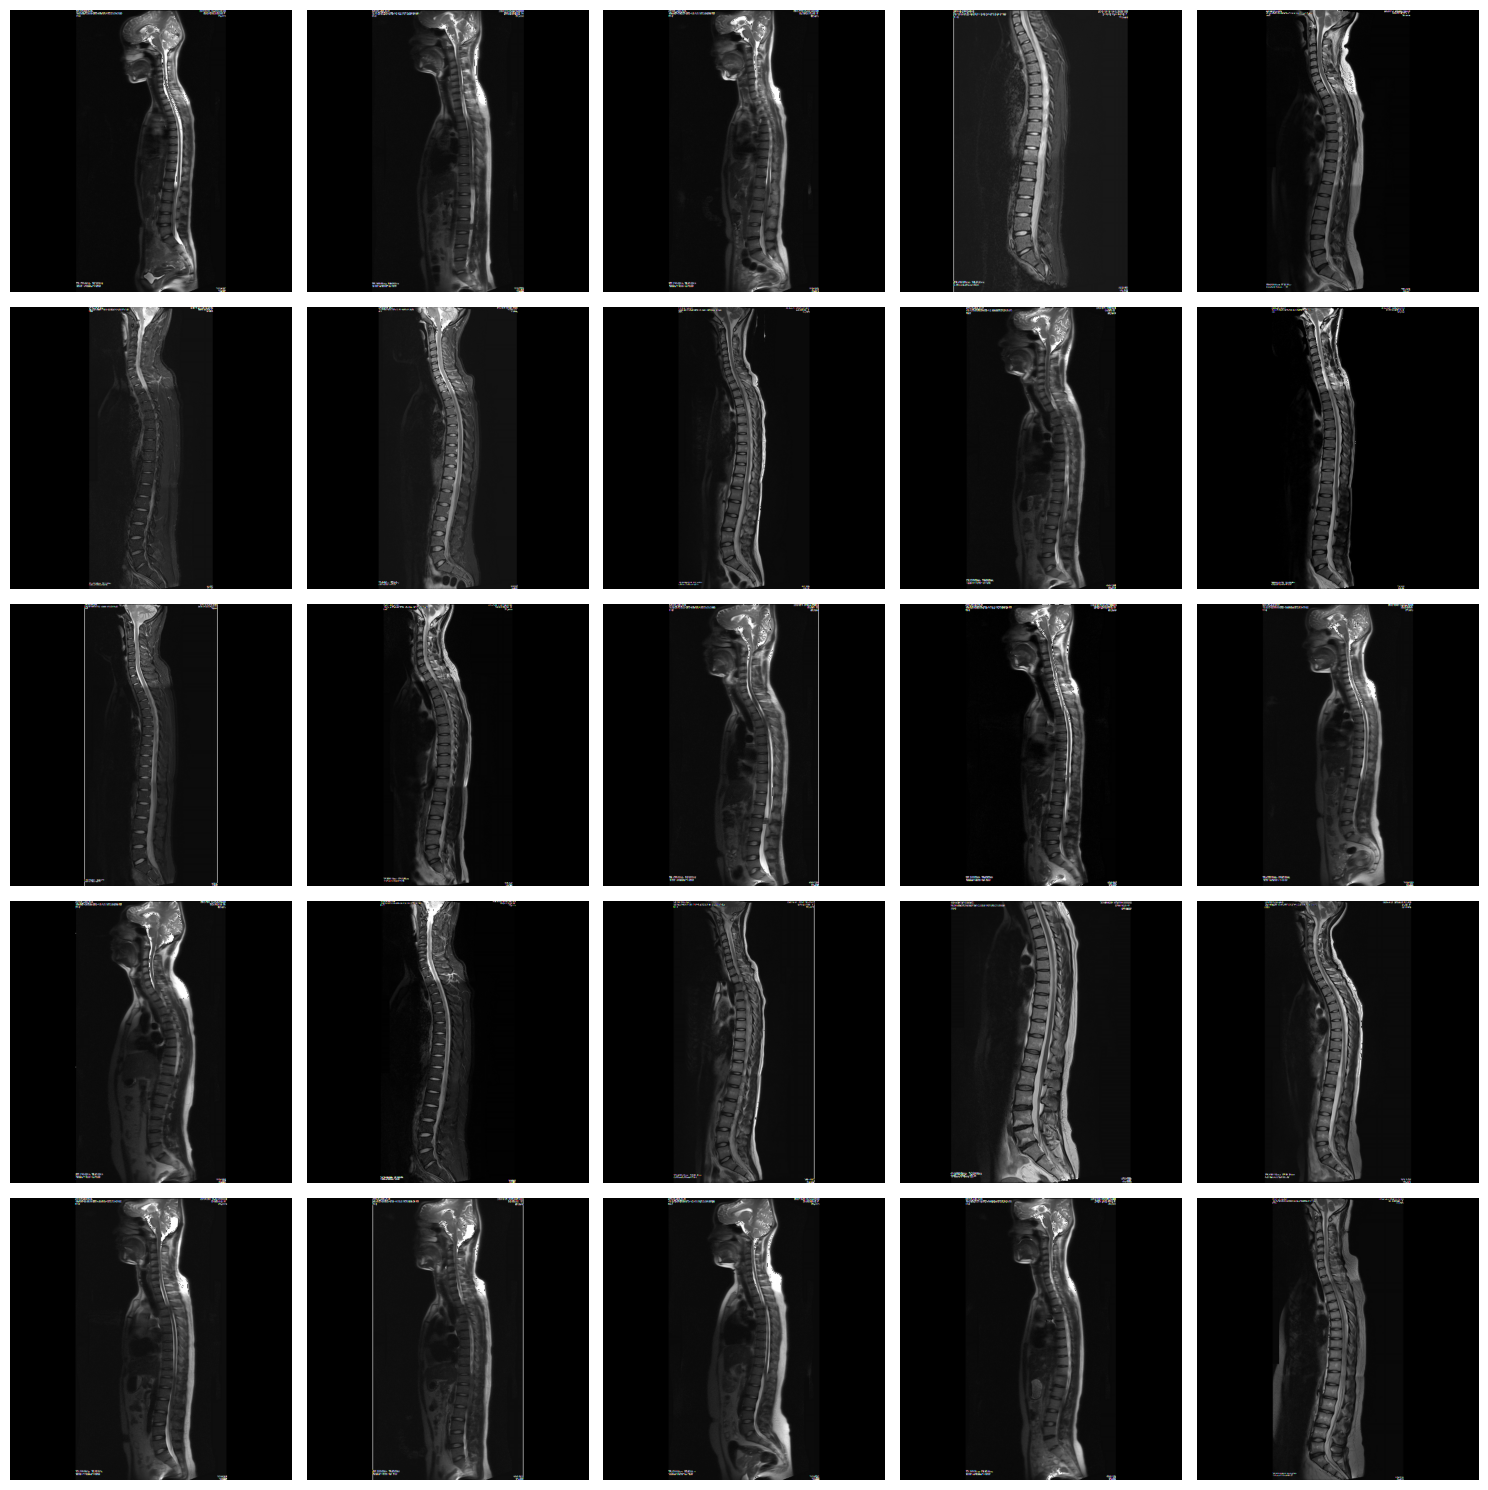

In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 假设 train_img 是一个包含多张图像的列表或Tensor
images = train_img
num_images = 25
rows = 5

indices = torch.randperm(len(images))[:num_images] # 如果不需要随机顺序，这行不需要
# 创建 figure 来显示图片
fig, axs = plt.subplots(rows, rows, figsize=(15, 15)) # 创建一个5x5的网格

for i, idx in enumerate(indices):
    img = images[idx]  # 直接使用索引获取图像

    # 计算行和列
    row = i // rows
    col = i % rows

    axs[row, col].imshow(img)
    axs[row, col].axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

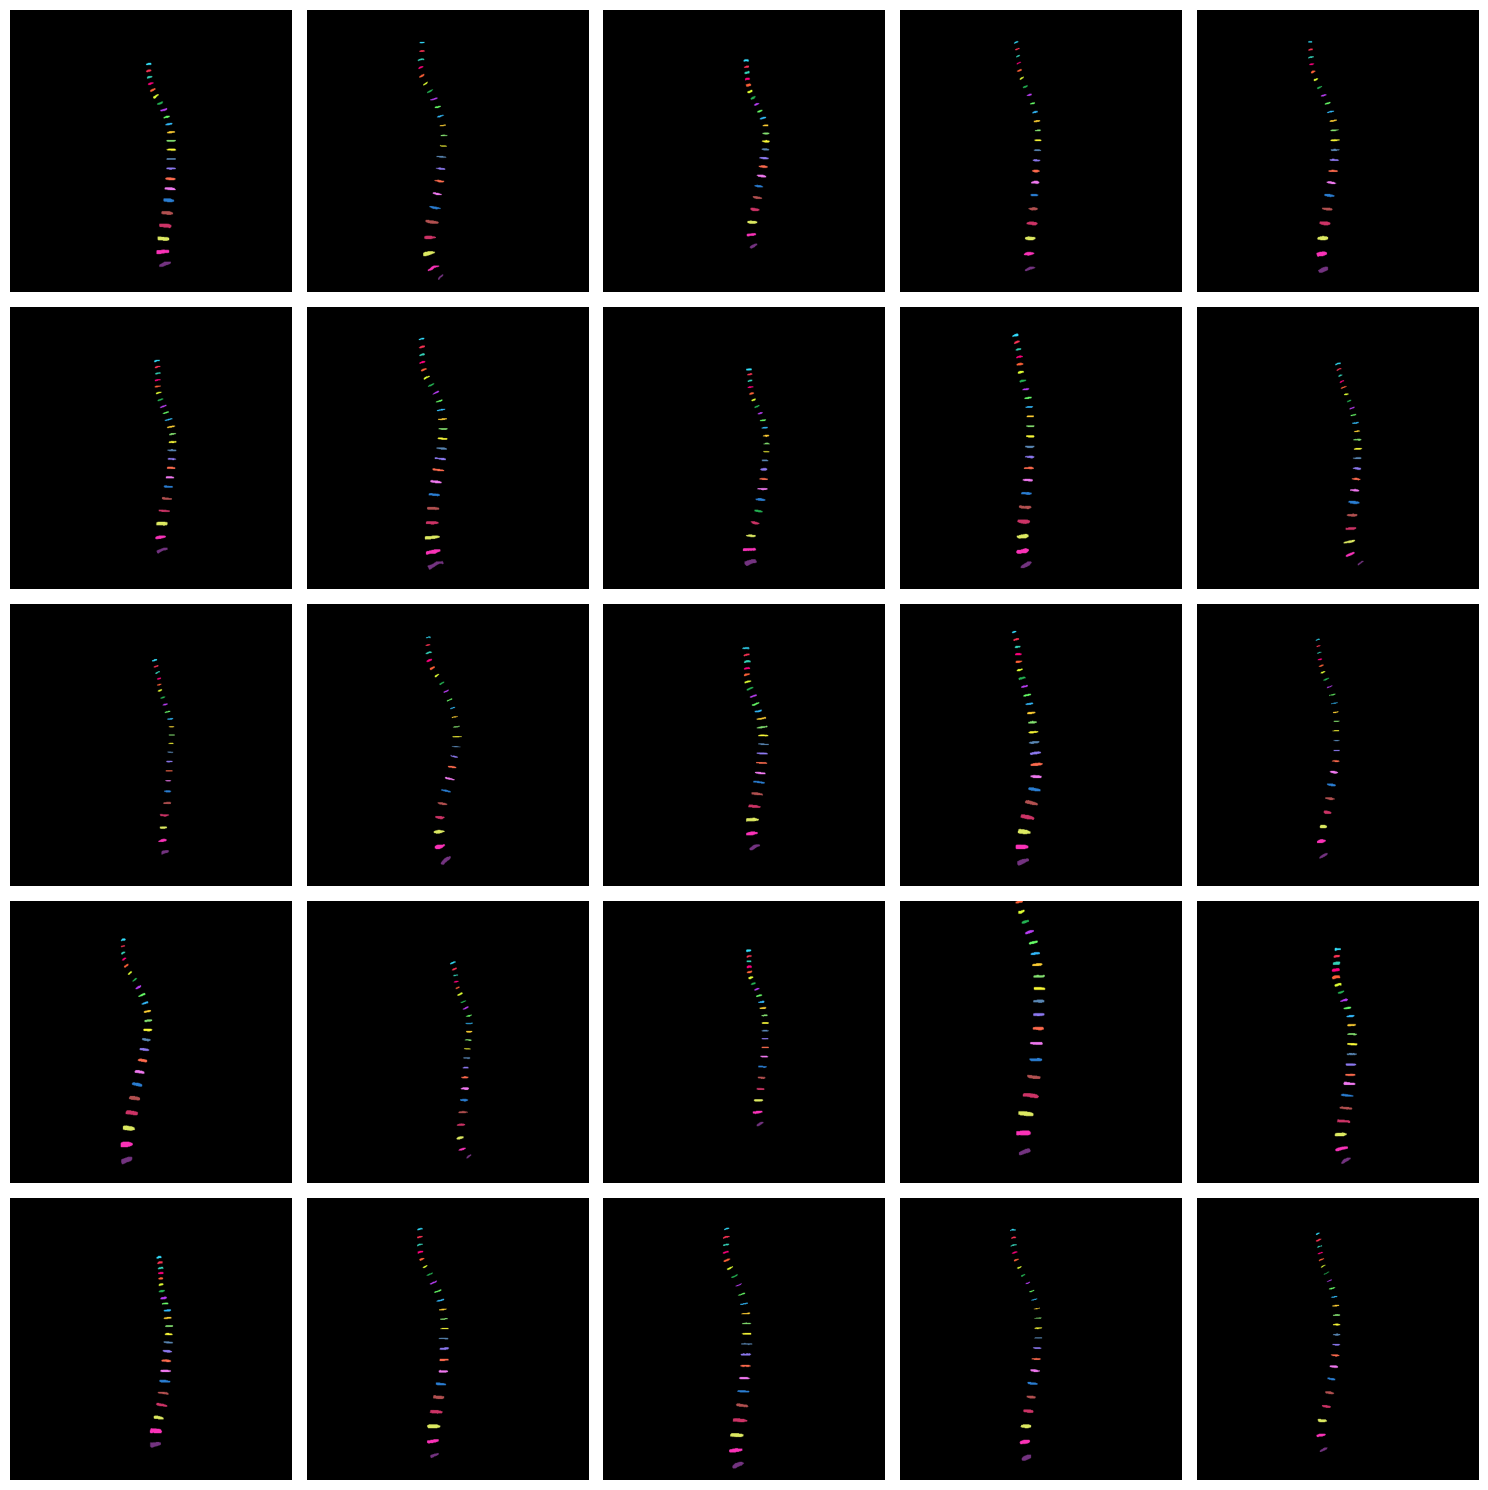

In [45]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 假设 train_img 是一个包含多张图像的列表或Tensor
images = train_label
num_images = 25
rows = 5

indices = torch.randperm(len(images))[:num_images] # 如果不需要随机顺序，这行不需要
# 创建 figure 来显示图片
fig, axs = plt.subplots(rows, rows, figsize=(15, 15)) # 创建一个5x5的网格

for i, idx in enumerate(indices):
    img = images[idx]  # 直接使用索引获取图像

    # 计算行和列
    row = i // rows
    col = i % rows

    axs[row, col].imshow(img)
    axs[row, col].axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

In [46]:
img.shape

torch.Size([512, 512, 3])

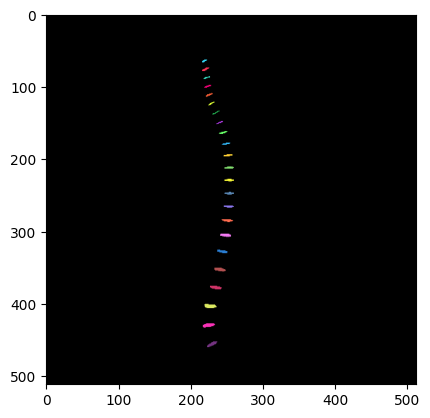

In [47]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
img_np = img.numpy() # 这里假设img Tensor被正确处理适合显示
# 正确使用plt显示图像
plt.imshow(img_np)
plt.show()

In [48]:
img = img.permute(2,0,1)
img.shape

torch.Size([3, 512, 512])

In [50]:
class Spine_Dataset(Dataset):
    def __init__(self,x:list,y:list,arg=False):
        super(Dataset,self).__init__()
        self.x=x#list[(C,H,W),...]
        self.y=y#list[(C,H,W),...]
        self.image_size=CFG.target_height
        self.in_chans=CFG.in_chans
        self.arg=arg
        if arg:
            self.transform=CFG.train_aug
        else: 
            self.transform=CFG.valid_aug

    def __len__(self) -> int:
        return sum([y.shape[0]-self.in_chans for y in self.y])
    
    def __getitem__(self,index):
        i=0
        for x in self.x:
            if index>x.shape[0]-self.in_chans:
                index-=x.shape[0]-self.in_chans
                i+=1
            else:
                break
        x=self.x[i]
        y=self.y[i]
        
        x=x[index:index+self.in_chans,:,:,:].to(torch.float32)
        y=y[index+self.in_chans//2,:,:,:].to(torch.float32)
        if self.in_chans == 1:
             x = x.squeeze(0)
             y = y.squeeze(0)
            
        # 应用任何预处理或增强转换
        data = self.transform(image=x.numpy(), mask=y.numpy())
        x = data['image']
        y = data['mask']
        
        y = y.permute(1, 2, 0)
        multilabel_mask = torch.zeros((23, y.shape[0], y.shape[1]), dtype=torch.float32)
        for num, (label, color) in enumerate(label_to_color.items()):
            mask_label_color = (y[:,:,0] == color[0]) & (y[:,:,1] == color[1]) & (y[:,:,2] == color[2])
            multilabel_mask[num] = torch.where(mask_label_color, torch.tensor(1.0, dtype=torch.float32), torch.tensor(0.0, dtype=torch.float32))
        
        binary_mask = torch.zeros((1, y.shape[0], y.shape[1]), dtype=torch.float32)  
        mask_label_color = (y[:,:,0] == 0) & (y[:,:,1] == 0) & (y[:,:,2] == 0)
        binary_mask = torch.where(mask_label_color, torch.tensor(0.0, dtype=torch.float32), torch.tensor(1.0, dtype=torch.float32))
        binary_mask = binary_mask.unsqueeze(0)

        return x, binary_mask, multilabel_mask

In [51]:
label_to_color = {
    'C2-3': [51, 221, 255],
    'C3-4': [250, 50, 83],
    'C4-5': [52, 209, 183],
    'C5-6': [255, 0, 124],
    'C6-7': [255, 96, 55],
    'C7-T1': [221, 255, 51],
    'L1-2': [178, 80, 80],
    'L2-3': [204, 51, 102],
    'L3-4': [220, 233, 97],
    'L4-5': [250, 50, 183],
    'L5-S1': [115, 51, 128],
    'T1-2': [36, 179, 83],
    'T10-11': [255, 106, 77],
    'T11-12': [240, 120, 240],
    'T12-L1': [42, 125, 209],
    'T2-3': [184, 61, 245],
    'T3-4': [102, 255, 102],
    'T4-5': [50, 183, 250],
    'T5-6': [255, 204, 51],
    'T6-7': [131, 224, 112],
    'T7-8': [250, 250, 55],
    'T8-9': [89, 134, 179],
    'T9-10': [140, 120, 240],
}

In [52]:
train_dataset = Spine_Dataset([train_img],[train_label],arg=False)
train_dataset = DataLoader(train_dataset, batch_size=CFG.train_batch_size ,num_workers=0, shuffle=True, pin_memory=True)
val_dataset = Spine_Dataset([valid_img],[valid_label])
val_dataset = DataLoader(val_dataset, batch_size=CFG.valid_batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [53]:
# 获取DataLoader的迭代器
data_iterator = iter(train_dataset)
# 从迭代器中获取第一个批次
first_batch = next(data_iterator)
print('img shape:',first_batch[0].shape,'label shape:',first_batch[1].shape)

img shape: torch.Size([16, 3, 512, 512]) label shape: torch.Size([16, 1, 512, 512])


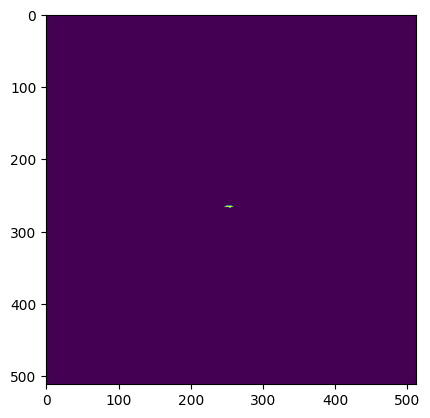

In [54]:
plt.imshow(first_batch[2][0][22])

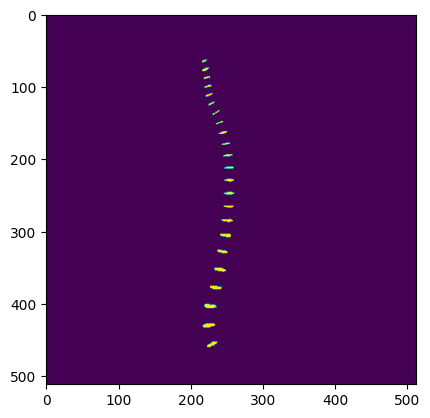

In [55]:
plt.imshow(first_batch[1][0][0])